In [19]:
import sys
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [21]:
tk = th.Thicket.from_caliperreader(glob("cali/*/*.cali"))

(2/2) Creating Thicket: 100%|██████████| 221/221 [00:00<00:00, 486.20it/s]
c:\Users\Surya\Documents\TAMU\TAMU_Y3S1\CSCE 435\.venv\Lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


View Calltree

In [22]:
print(tk.tree(metric_column="Avg time/rank"))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

2.546 main
├─ 0.875 MPI_Comm_dup
├─ 0.000 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Init
├─ 0.000 MPI_Initialized
├─ 0.006 comm
│  ├─ 0.002 MPI_Barrier
│  └─ 0.004 comm_large
│     ├─ 0.007 MPI_Recv
│     └─ 0.000 MPI_Send
├─ 0.101 comp
│  └─ 0.101 comp_large
├─ 0.030 correctness_check
└─ 0.015 data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 2.55 indices: {'profile': np.int64(25038463)})
█ 2.29 - 2.55
█ 1.78 - 2.29
█ 1.27 - 1.78
█ 0.76 - 1.27
█ 0.25 - 0.76
█ 0.00 - 0.25

name User code    ◀  Only in left graph    ▶  Only in right graph



In [23]:
extracted_md = tk.metadata[['algorithm', 'programming_model', 'data_type', 'size_of_data_type', 
          'input_size', 'input_type', 'num_procs', 'scalability', 
          'group_num', 'implementation_source']]
print(extracted_md.to_markdown(index=False))

| algorithm   | programming_model   | data_type   |   size_of_data_type |   input_size | input_type   |   num_procs | scalability   |   group_num | implementation_source   |
|:------------|:--------------------|:------------|--------------------:|-------------:|:-------------|------------:|:--------------|------------:|:------------------------|
| bitonic     | mpi                 | int         |                   4 |      4194304 | random       |          64 | strong        |           5 | handwritten             |
| bitonic     | mpi                 | int         |                   4 |     16777216 | perturbed    |           2 | strong        |           5 | handwritten             |
| bitonic     | mpi                 | int         |                   4 |      4194304 | sorted       |           2 | strong        |           5 | handwritten             |
| bitonic     | mpi                 | int         |                   4 |     67108864 | reverse      |           8 | strong      

Extract `algorithm`, `num_procs`, `input_size`, and `input_type` from metadata and inject into dataframe as columns.

In [24]:
tk.metadata_column_to_perfdata("algorithm")
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")

tk.dataframe = tk.dataframe.reset_index().set_index(["algorithm", "num_procs", "input_size", "input_type"]).sort_index()

In [25]:
perfdata = tk.dataframe.where(tk.dataframe['name'] == 'comp_large')
perfdata = perfdata.reset_index()
perfdata = perfdata[perfdata['profile'].notna()]
display(perfdata.head())

,algorithm,num_procs,input_size,input_type,node,profile,nid,spot.channel,Min time/rank,Max time/rank,Avg time/rank,Total time,Variance time/rank,Min time/rank (exc),Max time/rank (exc),Avg time/rank (exc),Total time (exc),Calls/rank (min),Calls/rank (avg),Calls/rank (max),Calls/rank (total),name
12,bitonic,2,65536,perturbed,"{'name': 'comp_large', 'type': 'function'}",3.655061e+09,6.0,regionprofile,0.022897,0.028040,0.025468,0.050936,0.000007,0.022897,0.028040,0.025468,0.050936,1.0,1.5,2.0,3.0,comp_large
27,bitonic,2,65536,random,"{'name': 'comp_large', 'type': 'function'}",1.352121e+09,6.0,regionprofile,0.028188,0.033607,0.030898,0.061796,0.000007,0.028188,0.033607,0.030898,0.061796,1.0,1.5,2.0,3.0,comp_large
42,bitonic,2,65536,reverse,"{'name': 'comp_large', 'type': 'function'}",1.488322e+08,6.0,regionprofile,0.022342,0.027976,0.025159,0.050319,0.000008,0.022342,0.027976,0.025159,0.050319,1.0,1.5,2.0,3.0,comp_large
57,bitonic,2,65536,sorted,"{'name': 'comp_large', 'type': 'function'}",8.242827e+08,6.0,regionprofile,0.024519,0.029875,0.027197,0.054394,0.000007,0.024519,0.029875,0.027197,0.054394,1.0,1.5,2.0,3.0,comp_large
72,bitonic,2,262144,perturbed,"{'name': 'comp_large', 'type': 'function'}",3.184030e+08,6.0,regionprofile,0.114094,0.137977,0.126035,0.252071,0.000143,0.114094,0.137977,0.126035,0.252071,1.0,1.5,2.0,3.0,comp_large


In [26]:
tk.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3330 entries, ('bitonic', np.int64(2), np.int64(65536), 'perturbed') to ('bitonic', np.int64(256), np.int64(268435456), 'sorted')
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   node                 3330 non-null   object 
 1   profile              3330 non-null   int64  
 2   nid                  3330 non-null   float64
 3   spot.channel         3330 non-null   object 
 4   Min time/rank        3330 non-null   float64
 5   Max time/rank        3330 non-null   float64
 6   Avg time/rank        3330 non-null   float64
 7   Total time           3330 non-null   float64
 8   Variance time/rank   3330 non-null   float64
 9   Min time/rank (exc)  3330 non-null   float64
 10  Max time/rank (exc)  3330 non-null   float64
 11  Avg time/rank (exc)  3330 non-null   float64
 12  Total time (exc)     3330 non-null   float64
 13  Calls/rank (min)     3108 non-nu

In [27]:
import os

def save_fig(path : str, filename : str):
    path_dirs = path.split('/')
    for i in range(len(path_dirs)):
        intermediate_path = '/'.join(path_dirs[:i+1])
        if not os.path.exists(intermediate_path):
            os.mkdir(intermediate_path)
    plt.savefig(os.path.join(path, filename))

def plot_rank_times(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Impact of Processors on Time / Rank (Input Size = {input_size})')

    for i, input_type in enumerate(input_types):
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]

        num_procs = df_by_type['num_procs']
        min_time = df_by_type['Min time/rank']
        avg_time = df_by_type['Avg time/rank']
        max_time = df_by_type['Max time/rank']

        ax = axs[i // 2, i % 2]
        ax.plot(num_procs, min_time, label='Min time/rank', marker='o')
        ax.plot(num_procs, avg_time, label='Avg time/rank', marker='o')
        ax.plot(num_procs, max_time, label='Max time/rank', marker='o')

        ax.set_title(f'Input Type: {input_type}')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Time (s)')
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_rank_a{input_size}.png')
    if show:
        plt.show()

def plot_total_time(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'Impact of Processors on Total Time (Input Size = {input_size})')
    
    for input_type in input_types:
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]
        total_time = df_by_type.groupby('num_procs')['Total time'].mean()
        ax.plot(total_time.index, total_time.values, label=f'Total time ({input_type})', marker='o')

    ax.set_xlabel('Number of Processors')
    ax.set_ylabel('Time (s)')
    ax.legend()
    plt.tight_layout()
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_total_a{input_size}.png')
    if show:
        plt.show()

def plot_variance_time(input_size: int, df_by_size: pd.DataFrame, input_types: list, algorithm: str, show=True, save=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'Impact of Processors on Variance Time/Rank (Input Size = {input_size})')
    
    for input_type in input_types:
        df_by_type = df_by_size[df_by_size['input_type'] == input_type]
        variance_time = df_by_type.groupby('num_procs')['Variance time/rank'].mean()
        ax.plot(variance_time.index, variance_time.values, label=f'Variance time ({input_type})', marker='o')

    ax.set_xlabel('Number of Processors')
    ax.set_ylabel('Time (s)')
    ax.legend()
    plt.tight_layout()
    if save:
        save_fig(f'plots/{algorithm}', f'{algorithm}_performance_variance_a{input_size}.png')
    if show:
        plt.show()

def plot_process_performance(perfdata : pd.DataFrame, algorithm : str, show=True, save=False):
    bitonic_df = perfdata[perfdata['algorithm'] == algorithm]
    
    input_sizes = bitonic_df['input_size'].unique()
    input_types = bitonic_df['input_type'].unique()

    for input_size in input_sizes:
        df_by_size = bitonic_df[bitonic_df['input_size'] == input_size]
        
        plot_rank_times(input_size, df_by_size, input_types, algorithm, show, save)
        plot_total_time(input_size, df_by_size, input_types, algorithm, show, save)
        plot_variance_time(input_size, df_by_size, input_types, algorithm, show, save)


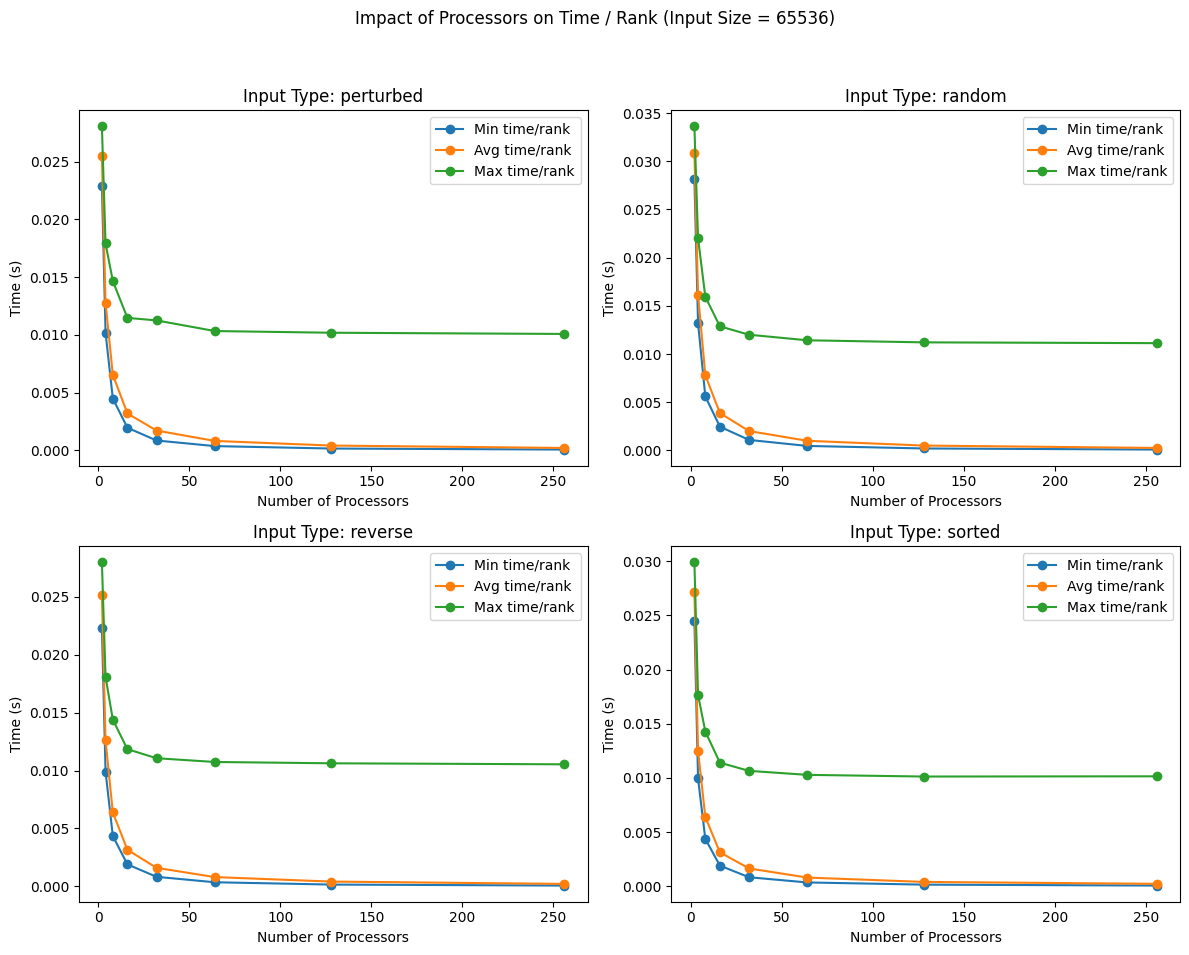

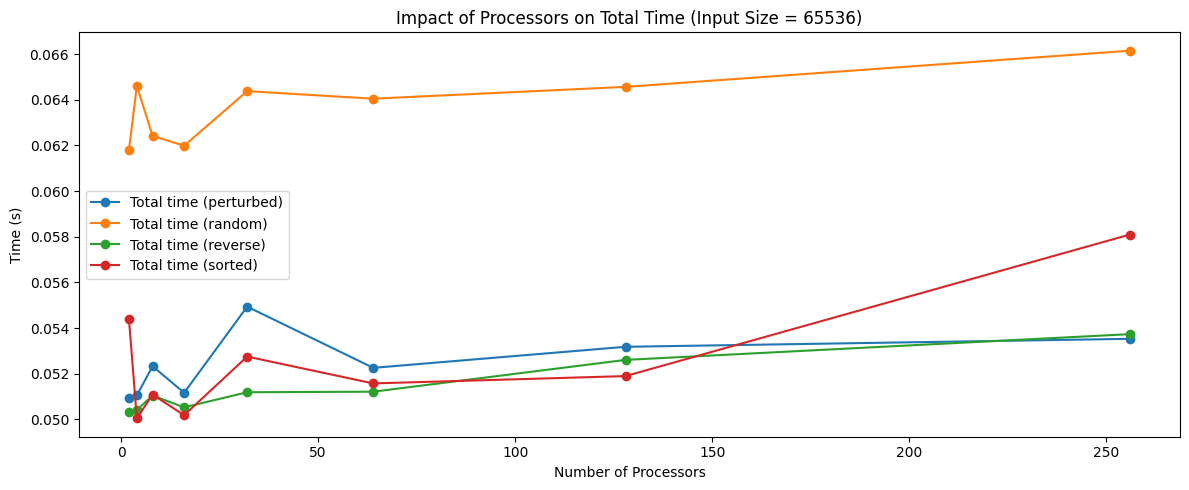

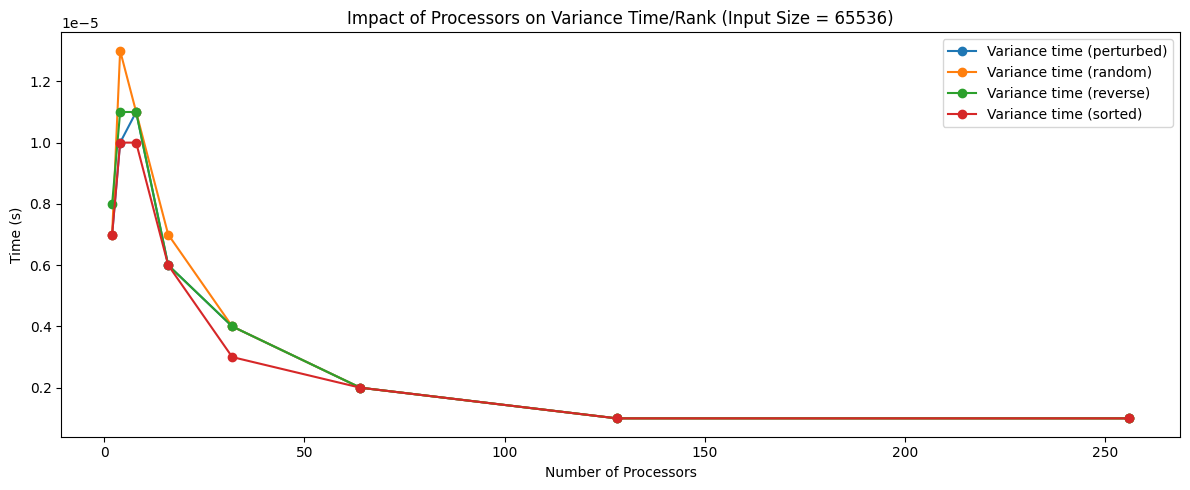

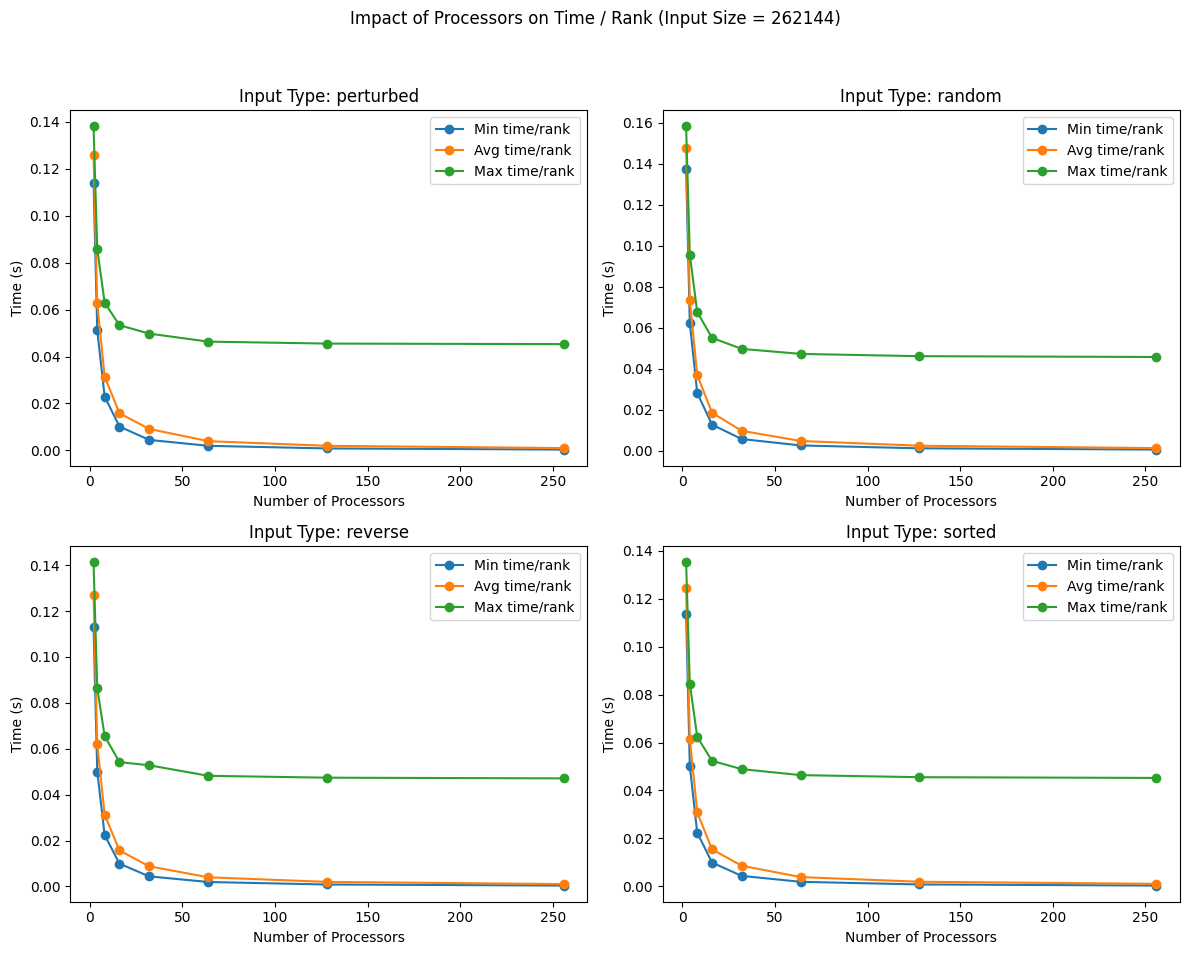

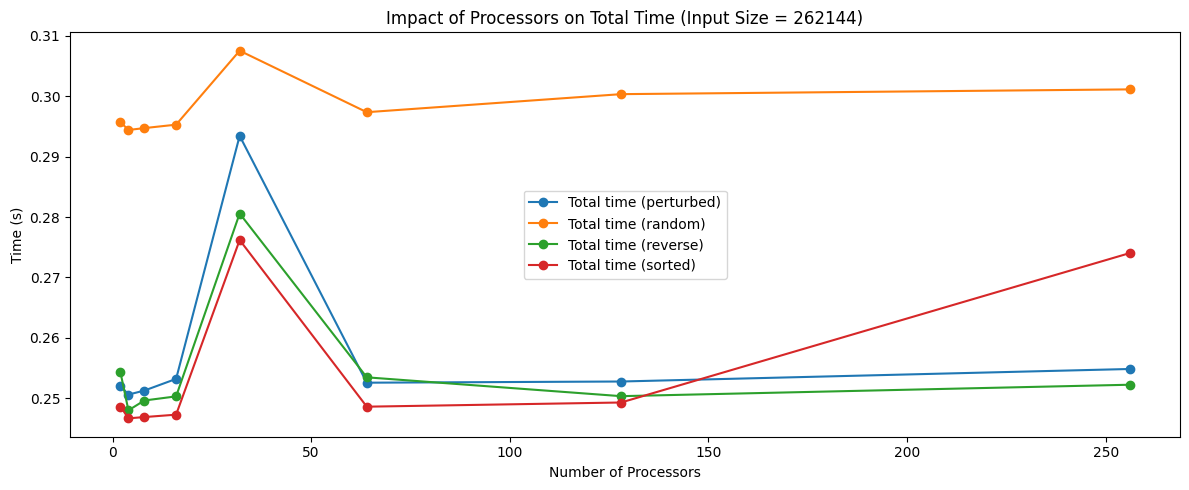

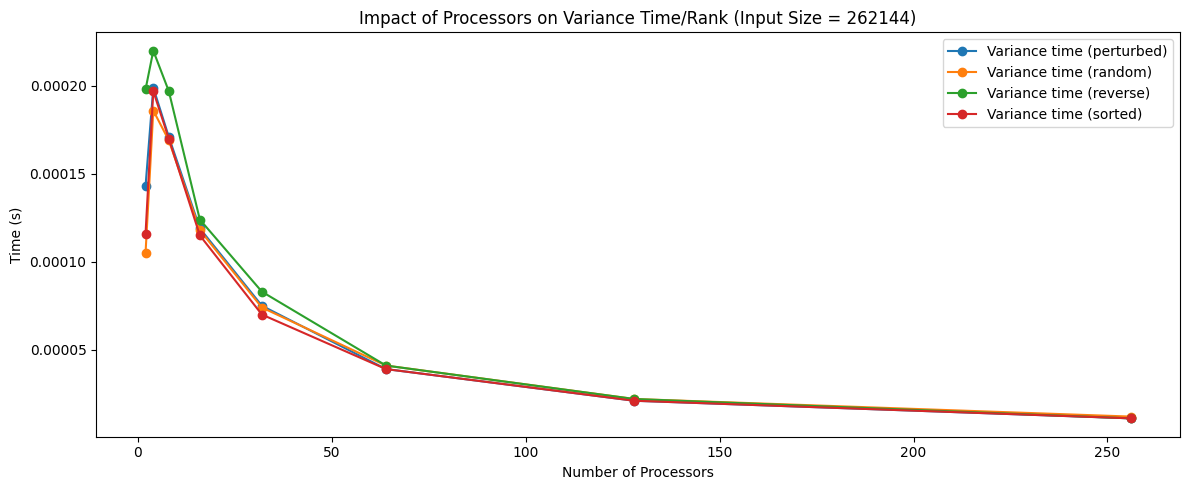

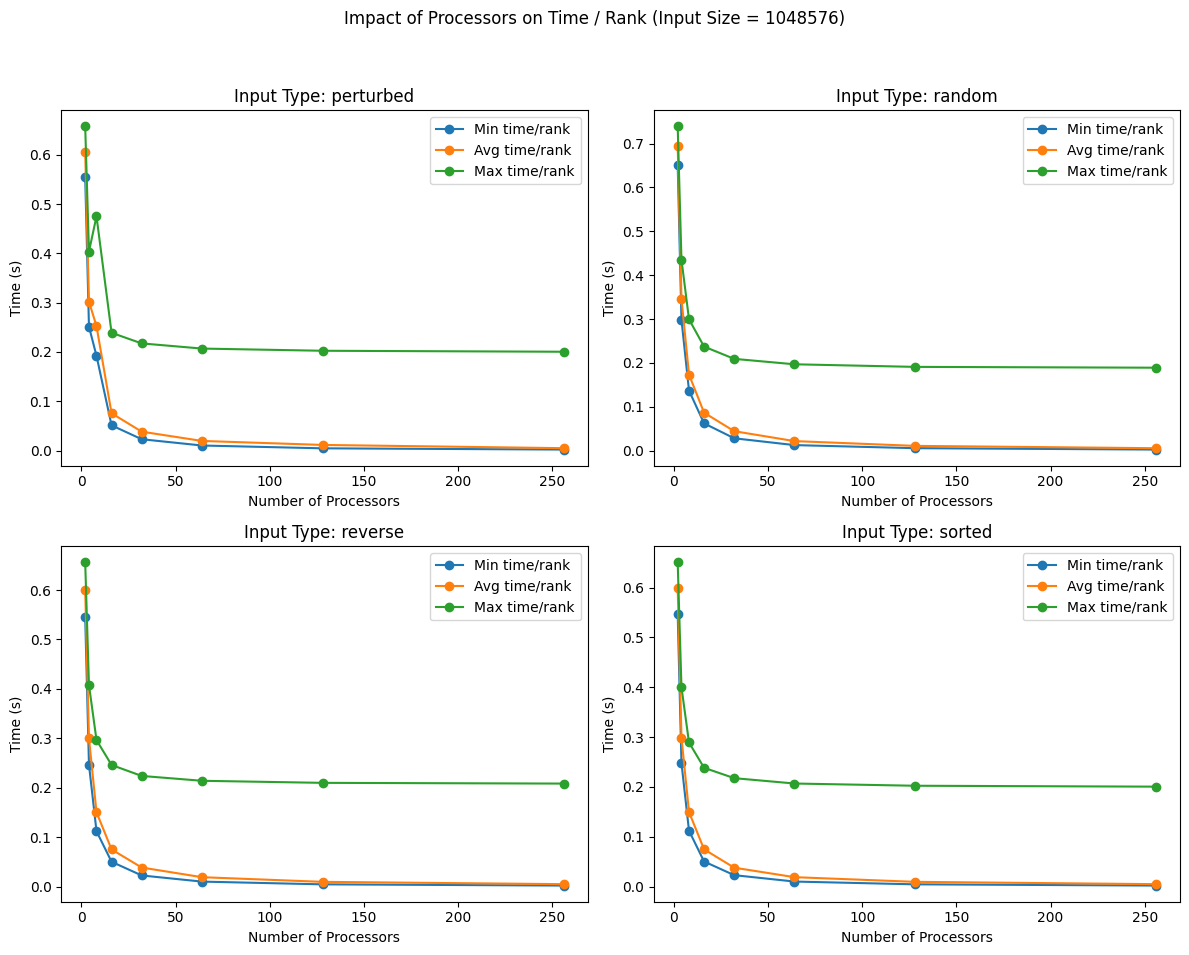

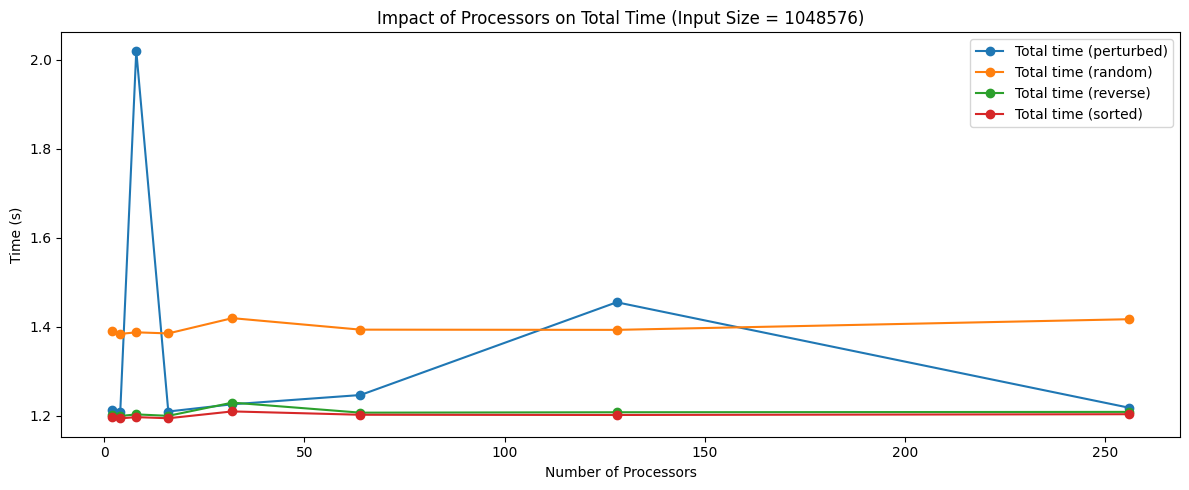

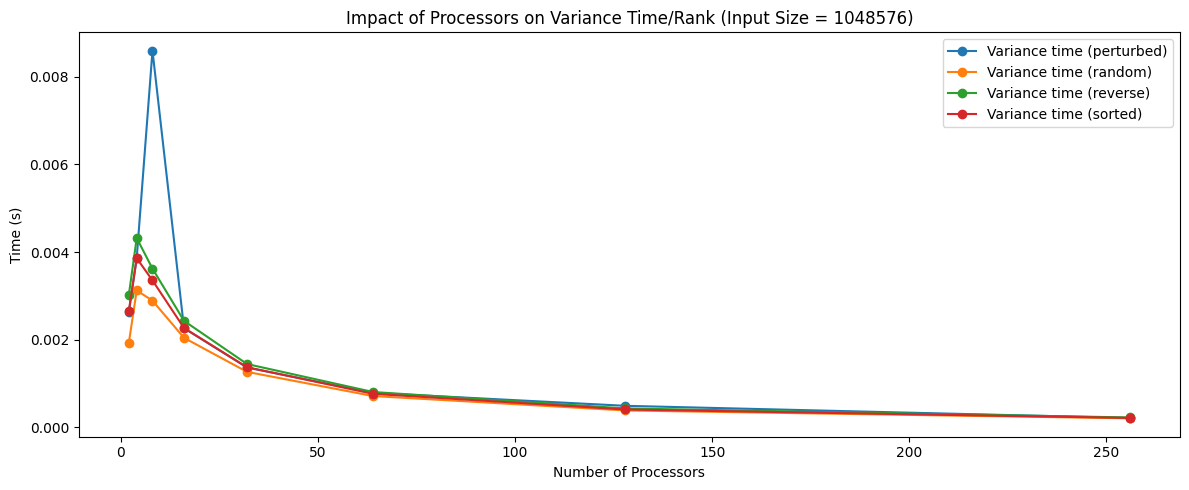

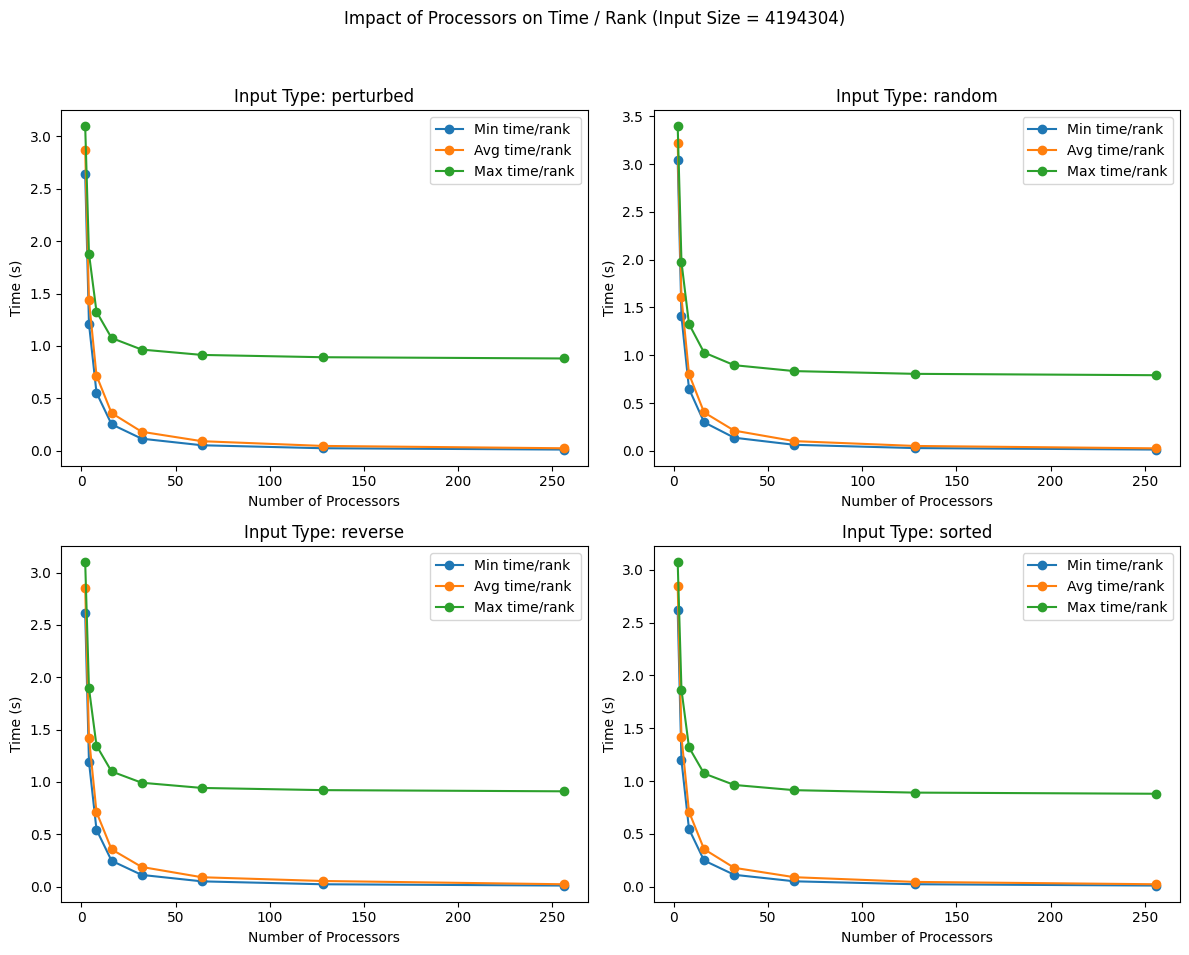

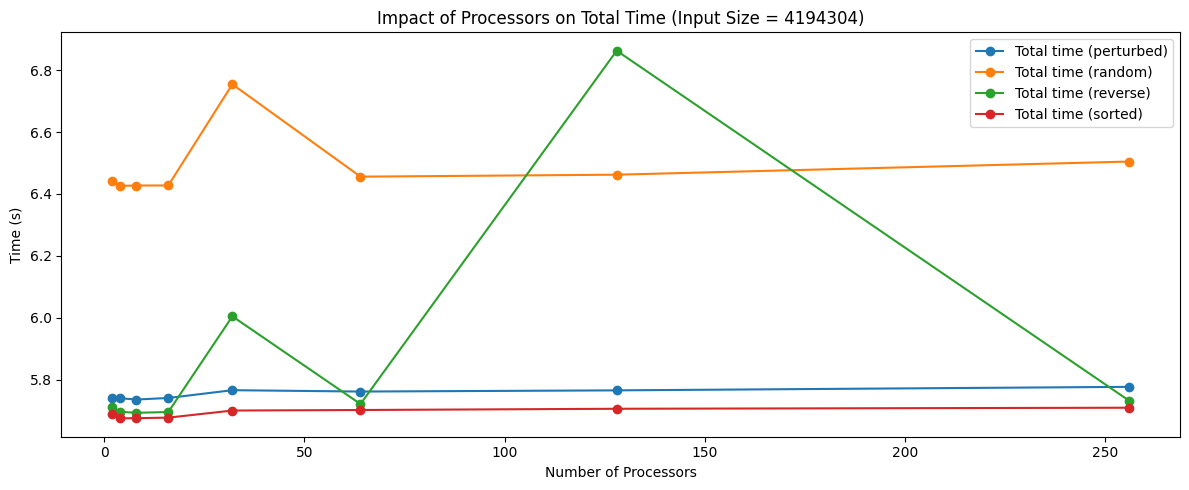

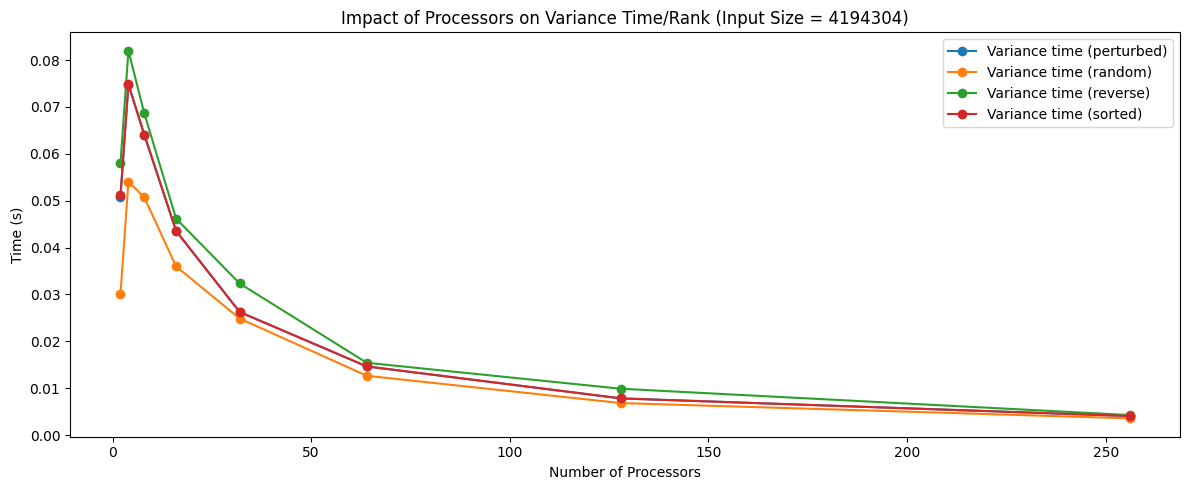

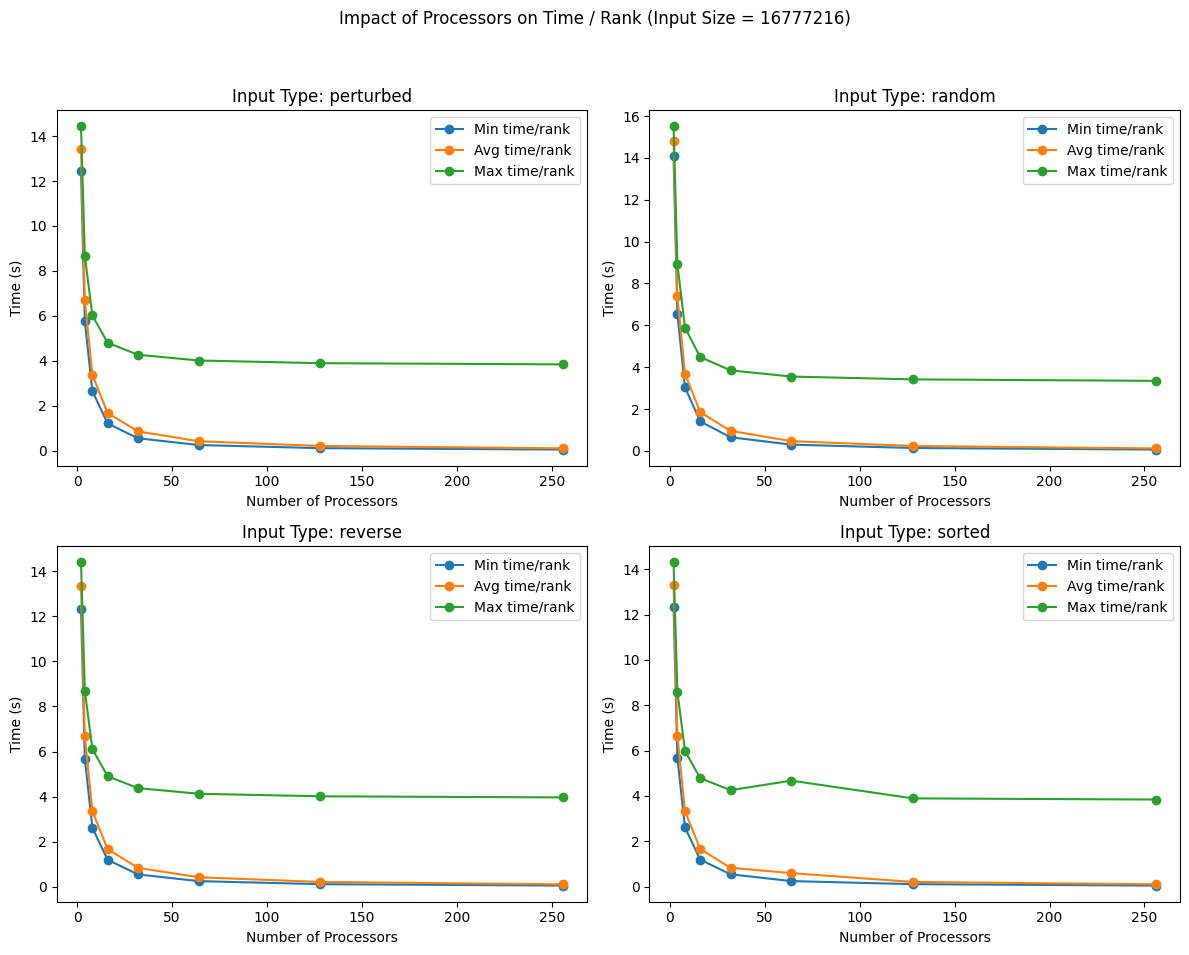

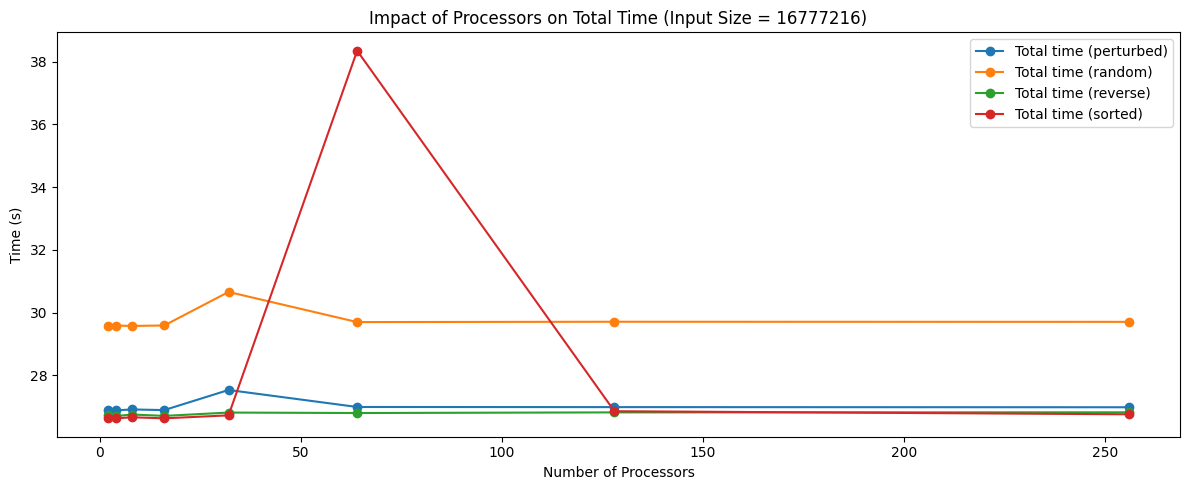

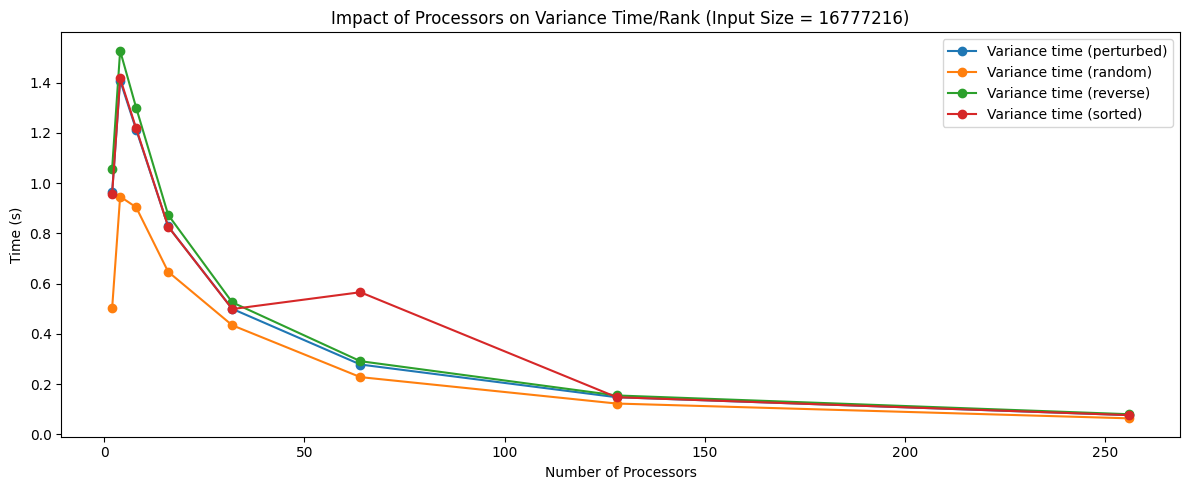

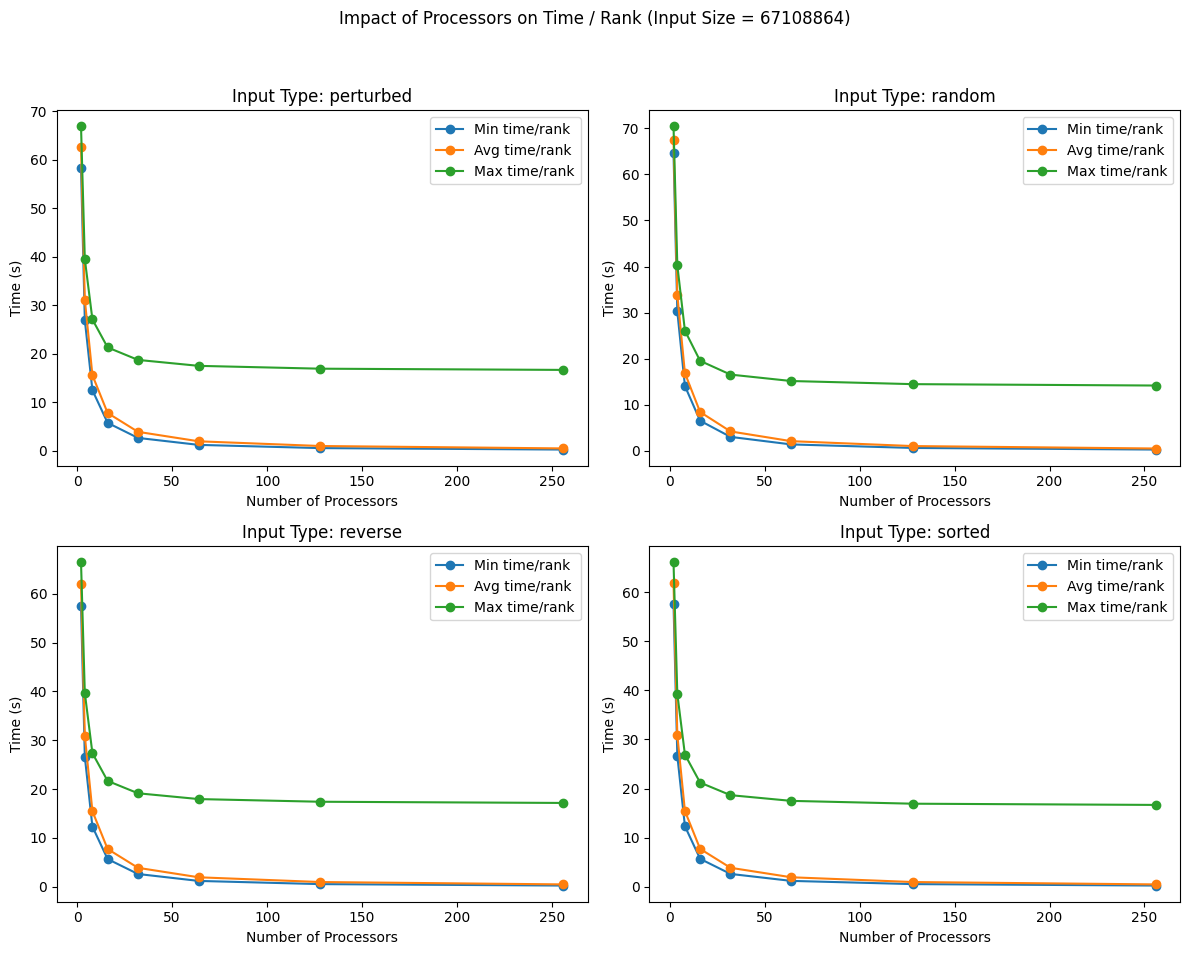

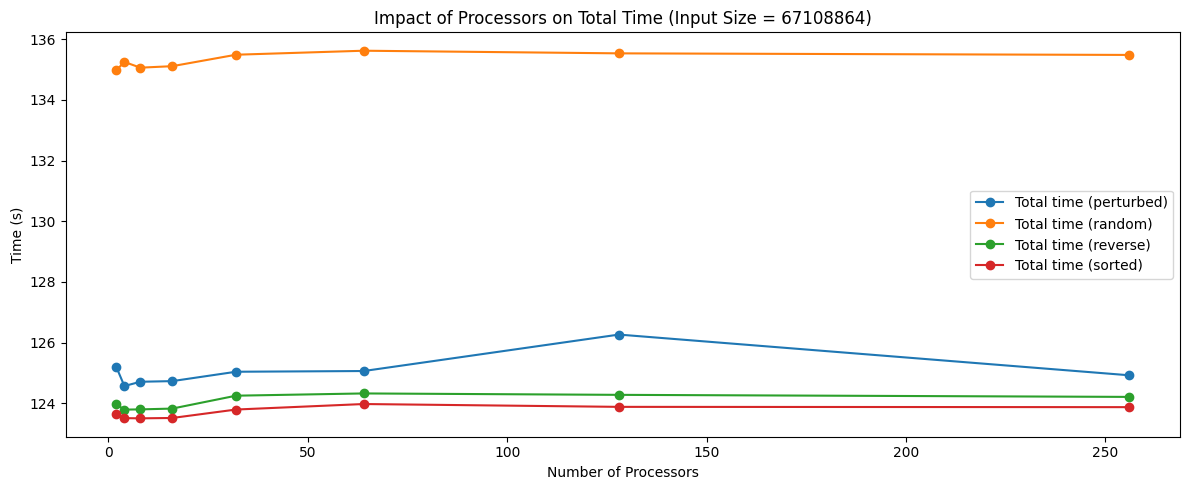

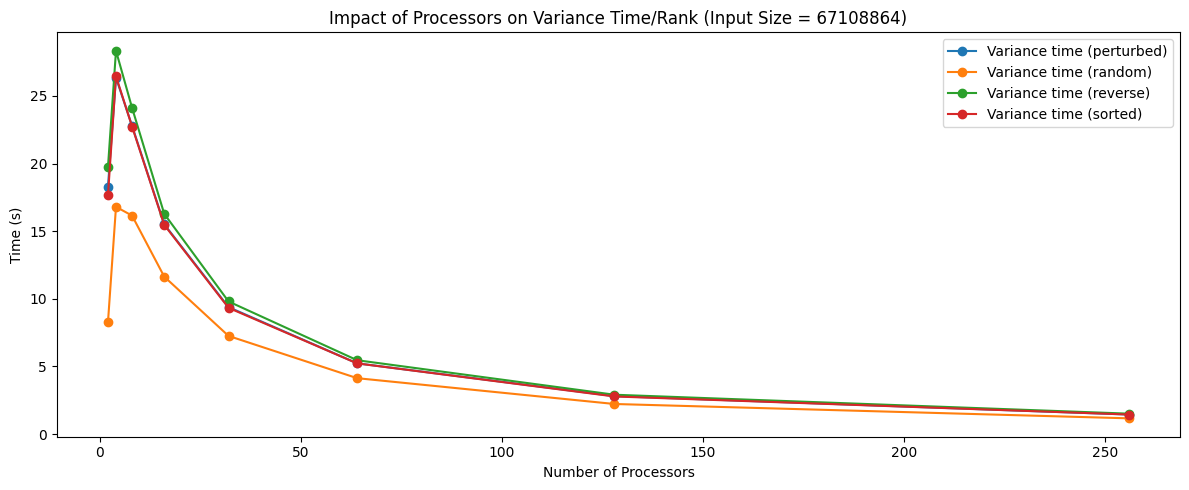

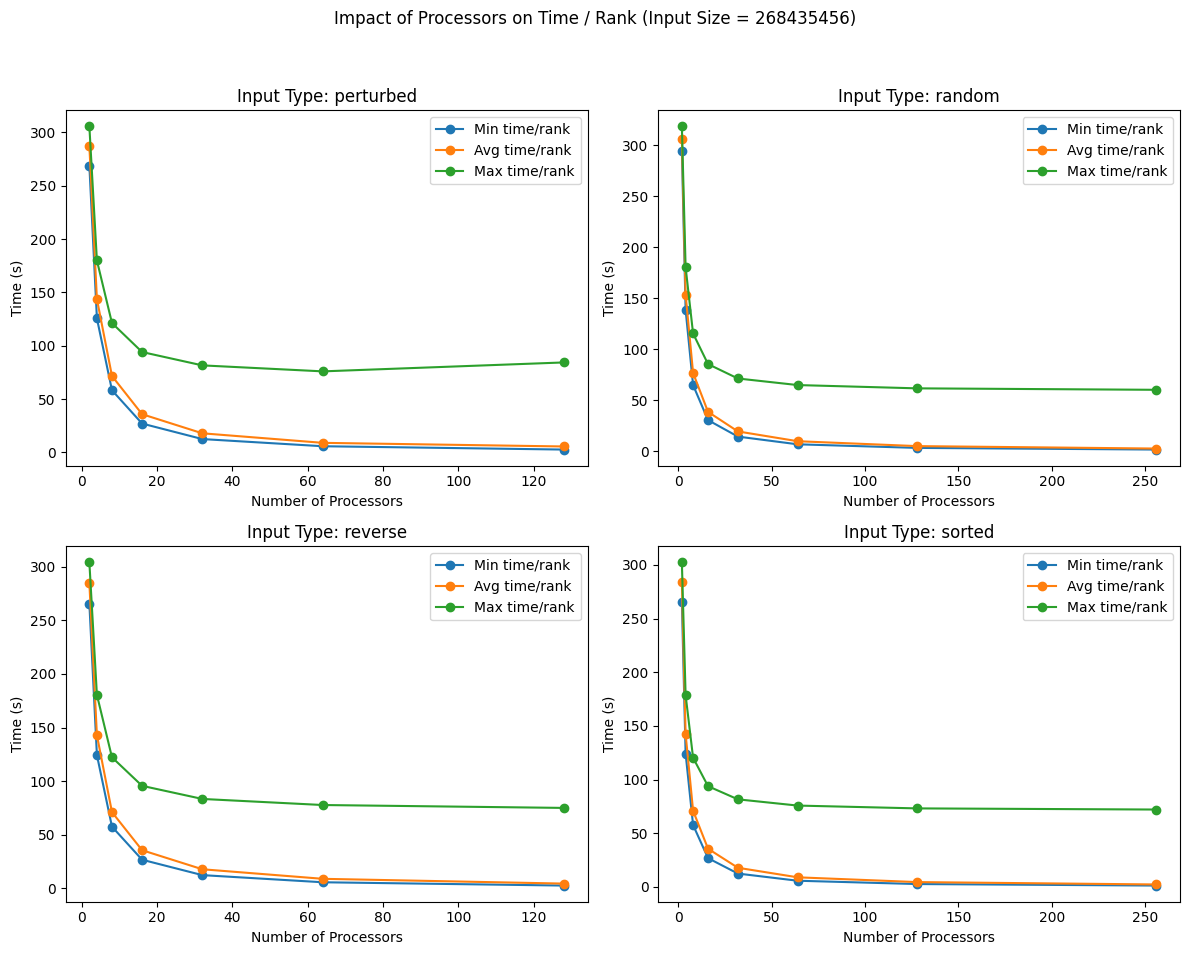

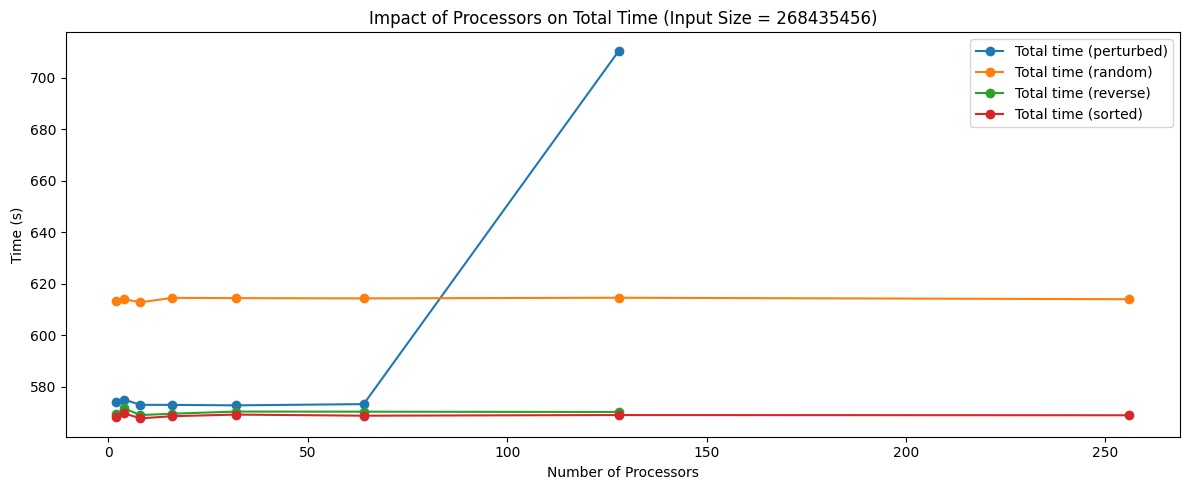

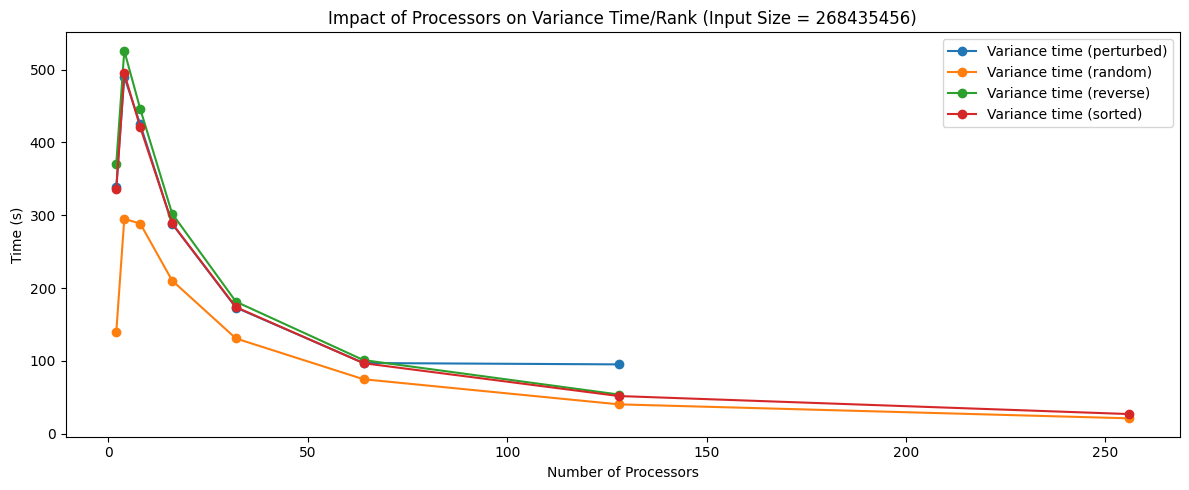

In [28]:
plot_process_performance(perfdata, 'bitonic', show=True, save=True)

As we can see from the above plots, the computation time by rank scales down negative exponentially as expected when we scale up the number of processors. This is because the bitonic sort implementation recursively divides the computational load between processors such that each only has to manage an even subarray. 

We also see that as we increase the input size, the exponential speedup by number of processes is maintained, while our total time does increase. This is expected as greater array sizes means increased computational costs per processor, additional memory allocation, and more data that needs to be communicated between processes. 

Another good indication is that the variance in computational time between processes likewise displays an exponential decay as we ramp up the number of processors. This is good news as it indicates this approach is evenly distributing the workload among processors. The key factor in this is the parallel merging algorithm I implemented that utilizes partner processes to hierarchically merge the locally sorted subarrays, trickling up into the master process's final sorted array.

Overall, the scalability of this approach is definitely quite strong as we ramp up the number of processors and exponentiate our input size, but there is definitely still room for improvement on cutting down communication costs and complexities.